# ERIKS Digital - Customer Migration Analysis 
In this analysis for ERIKS Digital, I was asked to analyse the order behaviour for a set of customers, who had been migrated from a previous version of our webshop, under a different company name (Zamro), to the webshop of ERIKS Digital. 
It is very similar in nature to ED_Conversion, and it's perhaps worth reading that notebook first. 

Part 1 - Migrated Customers Analysis
1. How many order did migrated customers place on the webshop since the migration? 
2. What is the breakdown of order channels for migrated customers? 
3. How has the percentage of orderlines placed by these customers changed since the migration? 
4. How has the total sales value for these customers changed over time? 
5. What is the industry breakdown for the migrated customer orders? 
6. How much of the orders placed by migrated customers could have been placed online? 
5. What is the average item value for migrated customers? 
6. What is the average orderline value for migrated customers? 
7. What does the sales value look like over time, for each industry? 
8. What does the sales value over time, by industry, look like for all offline orders? 
9. What does the sales value over time, by industry, look like for all webshop orders? 
10. Do the percentage of webshop orders, for migrated customers, look different across Business Units? 
11. How many offline orders could've been placed on the webshop, for each BU? 
12. Which BU has the highest percentage of offline orders, which could've been placed online? 

Part 2 - Discount Analysis
A 10% discount offer was given to some of the migrated customers, over the first month of the migration. 
1. Does the number of orders placed between discount and no discount customers look different at all?
2. How many customers fall into each group? 
3. What is the percentage of online orders for each customer group?
4. How many of the offline orders could have been placed online, for each customer group? 

# Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

# Part 1 - Migrated Customers Analysis 
## Customer ID Import
Customer IDs pulled from PBI Dashboard, all Zamro customers from 1st March 2019 to 25 October 2019

In [2]:
df_migration = pd.read_csv(r"Zamro_Migration_Deep_Dive_Data.csv")
df_migration.CustomerId = df_migration.CustomerId.astype(str) 
migration_customer_ids = df_migration['CustomerId'].unique()
df_migration_anon = df_migration.drop(['First CustomerName'], axis=1)
df_migration_anon.head()

CustomerId
0    1005507
1    1005936
2    1006397
3    1006824
4    1006977

## Create SQL Query to get orders data for customers

In [3]:
#Run this in SQL to update order data
sql_list = "("
for x in range(len(migration_customer_ids)):
    sql_list += "'" + str(migration_customer_ids[x]) + "'" + ", " 
sql_list = sql_list[:-2]
sql_list += ")"

script_after = "Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in %s" %sql_list
print (script_after)

Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in ('1005507', '1005936', '1006397', '1006824', '1006977', '1007514', '1007788', '1008045', '1008345', '1008499', '1008629', '1008953', '1009485', '1009723', '1010621', '1010639', '1010885', '1010910', '1011179', '1011410', '1012046', '1012050', '1012131', '1012344', '1012514', '1012519', '1012820', '1014108', '1014271', '1014387', '1015531', '1016686', '1017272', '1017431', '1017490', '1017599', '1019852', '1019952', '1020251', '1020784', '1021804', '1022088', '1022804', '1023176', '1026778', '1027198', '1027300', '1028693', '1029427', '1030644', '1031198', '1031531', '1031945', '1033361', '1033745', '103

## Import Orders data, saved to CSV from above SQL query

In [4]:
df_orders = pd.read_csv(r"Zamro_Migration_SQL_Data.csv")
df_orders_anon = df_orders.drop(['CustomerName'], axis=1)
df_orders_anon.head()

OriginalOrderNumber  OrderNumber  CustomerId TurnoverClass  \
0      350452872/10/1    350452872     1012050           NaN   
1        9092301/10/1      9092301     1005936           NaN   
2        9092301/20/1      9092301     1005936           NaN   
3        9092301/30/1      9092301     1005936           NaN   
4        9092301/40/1      9092301     1005936           NaN   

  IndustryCode2Description ArticleProdGroupNL PurchaseOrderTypeDescription  \
0      Basic Ind. Metal eo                 40                      Offline   
1         Other industries                 C1                      Webshop   
2         Other industries                 C1                      Webshop   
3         Other industries                 C1                      Webshop   
4         Other industries                 C1                      Webshop   

  SalesDocumentHeaderCreationDate  SalesValue  Quantity  \
0                       8/15/2019      416.00     200.0   
1                       8/14/2019       17.11       1.0   
2                       8/14/2019       11.45       1.0   
3                       8/14/2019       12.19       1.0   
4                       8/14/2019       22.20       1.0   

  MaterialGroup2Description  
0         General published  
1         General published  
2         General published  
3         General published  
4         General published

## Sanity check

In [5]:
df_orders['CustomerId'].nunique()

258

## Data Cleaning

In [6]:
df_orders.TurnoverClass = df_orders.TurnoverClass.astype(str)
df_orders.CustomerId = df_orders.CustomerId.astype(str)
df_orders['SalesDocumentHeaderCreationDate'] = pd.to_datetime(df_orders['SalesDocumentHeaderCreationDate'])

## Sanity check orders per month - check against dashboard

Text(0, 0.5, 'Number of Orderlines')

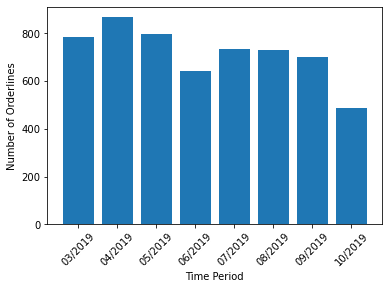

In [7]:
df_orders_grouped = df_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_group_sizes = []
for name, group in df_orders_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes.append(len(group.index))

plt.bar(list_of_date_bins, list_of_group_sizes)
plt.xticks(rotation = 45)
plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")

## See breakup of channels by month

Text(0.5, 1.0, 'Orderlines Breakdown for Migrated Customers')

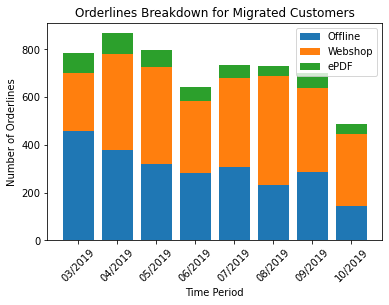

In [8]:
migrated_offline_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_webshop_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_epdf_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_group_sizes_offline = []
for name, group in migrated_offline_df:
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_offline.append(group.shape[0])

list_of_date_bins_webshop = []
list_of_group_sizes_webshop = []
for name, group in migrated_webshop_df:
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_webshop.append(group.shape[0])
    
list_of_date_bins_epdf = []
list_of_group_sizes_epdf = []
for name, group in migrated_epdf_df:
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_epdf.append(group.shape[0])
    
offline_plus_webshop = [x + y for x, y in zip(list_of_group_sizes_offline, list_of_group_sizes_webshop)]

plt.bar(list_of_date_bins_offline, list_of_group_sizes_offline, label = 'Offline')
plt.bar(list_of_date_bins_webshop, list_of_group_sizes_webshop, bottom = list_of_group_sizes_offline, label = 'Webshop')
plt.bar(list_of_date_bins_epdf, list_of_group_sizes_epdf, bottom = offline_plus_webshop, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")
plt.title("Orderlines Breakdown for Migrated Customers")

In [9]:
# Comments
# Webshop orders increasing over time, Offline orders look to be decreasing over time 

## Average % Online orderlines per customer per month

Text(0, 0.5, 'Percentage')

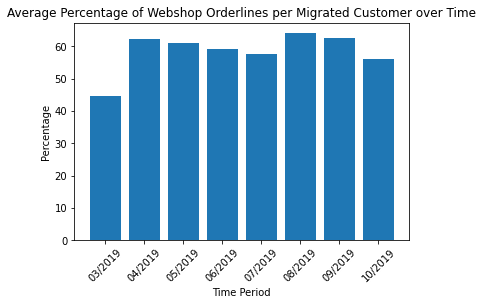

In [10]:
migrated_customer_orders_df_grouped = df_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_average_online_orders = []
for name, group in migrated_customer_orders_df_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_averages_in_one_month = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_averages_in_one_month.append( len(customer_dataframe[customer_dataframe['PurchaseOrderTypeDescription'] == 'Webshop']) / len(customer_dataframe))
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_online_orders.append(100*np.mean(list_of_customer_averages_in_one_month))
plt.bar(list_of_date_bins, list_of_average_online_orders)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Percentage of Webshop Orderlines per Migrated Customer over Time")
plt.ylabel("Percentage")

In [11]:
# Percentage of online orders for migrated customers quickly reaches values similar to "Still Online group"
# More impressive webshop uptake of Zamro customers than of Converted customers

## Sales Value over time

Text(0.5, 1.0, 'Sales Value for Migrated Customers over Time')

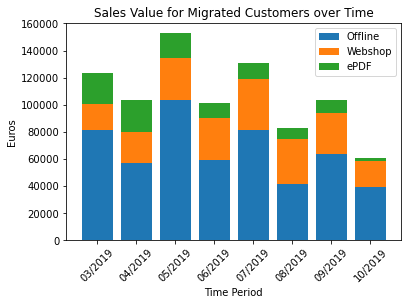

In [12]:
migrated_offline_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_webshop_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_epdf_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_sales_values_offline = []
for name, group in migrated_offline_df:
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_sales_values_offline.append(group.SalesValue.sum())

list_of_date_bins_webshop = []
list_of_sales_values_webshop = []
for name, group in migrated_webshop_df:
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_sales_values_webshop.append(group.SalesValue.sum())
    
list_of_date_bins_epdf = []
list_of_sales_values_epdf = []
for name, group in migrated_epdf_df:
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_sales_values_epdf.append(group.SalesValue.sum())
    
offline_plus_webshop = [x + y for x, y in zip(list_of_sales_values_offline, list_of_sales_values_webshop)]

plt.bar(list_of_date_bins_offline, list_of_sales_values_offline, label = 'Offline')
plt.bar(list_of_date_bins_webshop, list_of_sales_values_webshop, bottom = list_of_sales_values_offline, label = 'Webshop')
plt.bar(list_of_date_bins_epdf, list_of_sales_values_epdf, bottom = offline_plus_webshop, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Euros")
plt.title("Sales Value for Migrated Customers over Time")

## Industry Breakdown

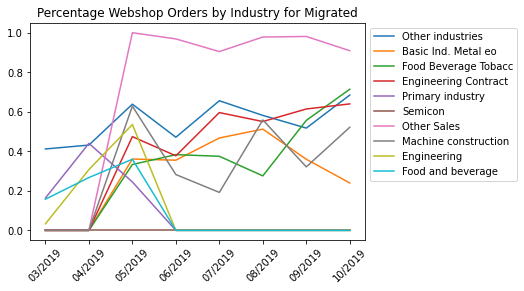

In [13]:
migrated_customer_orders_df_grouped = df_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_industries = df_orders.IndustryCode2Description.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

for name, group in migrated_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df_migrated = pd.DataFrame(0.0, columns = list_of_industries, index = list_of_date_bins) 

for name, group in migrated_customer_orders_df_grouped:   
    only_webshop_for_scaling_df = group[group['PurchaseOrderTypeDescription'] == 'Webshop']
    only_webshop_for_scaling_df = only_webshop_for_scaling_df[only_webshop_for_scaling_df["IndustryCode2Description"].isin(list_of_industries)]    
    months_industry_df = group.groupby(["IndustryCode2Description"]).count()["CustomerId"].reset_index(name='count')
    only_webshop_for_scaling_df = only_webshop_for_scaling_df.groupby(["IndustryCode2Description"]).count()["CustomerId"].reset_index(name='count')

    for i in list_of_industries:
        list_of_active_industries_in_month = months_industry_df['IndustryCode2Description'].unique()
        list_of_active_webshop_industries_in_month = only_webshop_for_scaling_df['IndustryCode2Description'].unique()
        if i in list_of_active_industries_in_month and i in list_of_active_webshop_industries_in_month:            
            df_migrated.loc[name.date().strftime('%m/%Y')].at[i] = (1.0*only_webshop_for_scaling_df.loc[only_webshop_for_scaling_df['IndustryCode2Description'] == i, 'count'].iloc[0]) / (1.0*months_industry_df.loc[months_industry_df['IndustryCode2Description'] == i, 'count'].iloc[0]) 

df_migrated.plot()
plt.xticks(rotation = 45)
plt.title("Percentage Webshop Orders by Industry for Migrated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)


## Offline Order Analysis

Text(0.5, 1.0, 'Breakup of Offline Orders per Month for Migrated Customers')

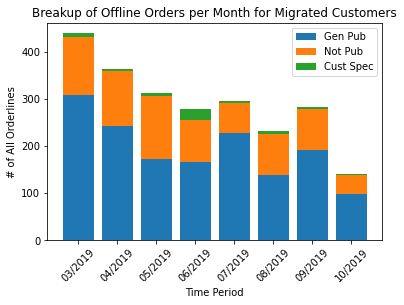

In [14]:
migrated_offline_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Offline']
migrated_genpub_df = migrated_offline_df[migrated_offline_df['MaterialGroup2Description'] == 'General published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_notpub_df = migrated_offline_df[migrated_offline_df['MaterialGroup2Description'] == 'Do not publish'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_custspec_df = migrated_offline_df[migrated_offline_df['MaterialGroup2Description'] == 'Customer-specific published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_genpub = []
list_of_group_sizes_genpub = []
for name, group in migrated_genpub_df:
    list_of_date_bins_genpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_genpub.append(group.shape[0])

list_of_date_bins_notpub = []
list_of_group_sizes_notpub = []
for name, group in migrated_notpub_df:
    list_of_date_bins_notpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_notpub.append(group.shape[0])
    
list_of_date_bins_custspec = []
list_of_group_sizes_custspec = []
for name, group in migrated_custspec_df:
    list_of_date_bins_custspec.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_custspec.append(group.shape[0])

list_of_group_sizes_genpub_normed = [x*100 / (float(len(df_orders))) for x in list_of_group_sizes_genpub]
list_of_group_sizes_notpub_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_notpub]
list_of_group_sizes_custspec_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_custspec]

genpub_plus_notpub = [x + y for x, y in zip(list_of_group_sizes_genpub, list_of_group_sizes_notpub)]
genpub_plus_notpub_normed = [x + y for x, y in zip(list_of_group_sizes_genpub_normed, list_of_group_sizes_notpub_normed)]

plt.bar(list_of_date_bins_genpub, list_of_group_sizes_genpub, label = 'Gen Pub')
plt.bar(list_of_date_bins_notpub, list_of_group_sizes_notpub, bottom = list_of_group_sizes_genpub, label = 'Not Pub')
plt.bar(list_of_date_bins_custspec, list_of_group_sizes_custspec, bottom = genpub_plus_notpub, label = 'Cust Spec')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("# of All Orderlines")
plt.title("Breakup of Offline Orders per Month for Migrated Customers")

## Average Item Value

Text(0.5, 1.0, 'Average Item Value for Migrated Customers')

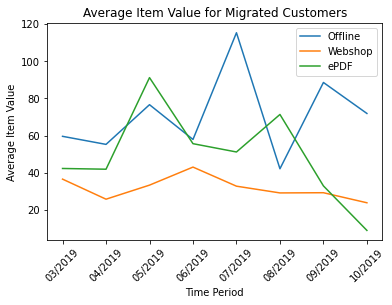

In [15]:
df_orders['ItemValue'] = df_orders.SalesValue / df_orders.Quantity

migrated_offline_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_webshop_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_edi_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'EDI'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_epdf_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_group_sizes_offline = []
for name, group in migrated_offline_df:
    mean_item_value_of_month = group['ItemValue'].mean()
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_offline.append(mean_item_value_of_month)

list_of_date_bins_webshop = []
list_of_group_sizes_webshop = []
for name, group in migrated_webshop_df:
    mean_item_value_of_month = group['ItemValue'].mean()
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_webshop.append(mean_item_value_of_month)
    
list_of_date_bins_edi = []
list_of_group_sizes_edi = []
for name, group in migrated_edi_df:
    mean_item_value_of_month = group['ItemValue'].mean()
    list_of_date_bins_edi.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_edi.append(mean_item_value_of_month)
    
list_of_date_bins_epdf = []
list_of_group_sizes_epdf = []
for name, group in migrated_epdf_df:
    mean_item_value_of_month = group['ItemValue'].mean()
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_epdf.append(mean_item_value_of_month)

plt.plot(list_of_date_bins_offline, list_of_group_sizes_offline, label = 'Offline')
plt.plot(list_of_date_bins_webshop, list_of_group_sizes_webshop, label = 'Webshop')
plt.plot(list_of_date_bins_epdf, list_of_group_sizes_epdf, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("Average Item Value")
plt.title("Average Item Value for Migrated Customers")

## AOLV

Text(0.5, 1.0, 'AOLV for Migrated Customers')

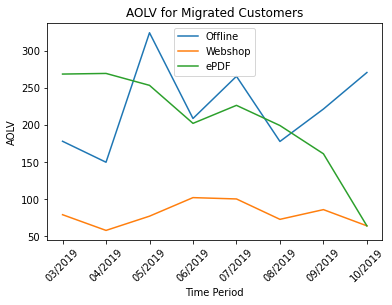

In [16]:
migrated_offline_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_webshop_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_edi_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'EDI'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
migrated_epdf_df = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'ePDF'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_offline = []
list_of_group_sizes_offline = []
for name, group in migrated_offline_df:
    mean_item_value_of_month = group['SalesValue'].mean()
    list_of_date_bins_offline.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_offline.append(mean_item_value_of_month)

list_of_date_bins_webshop = []
list_of_group_sizes_webshop = []
for name, group in migrated_webshop_df:
    mean_item_value_of_month = group['SalesValue'].mean()
    list_of_date_bins_webshop.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_webshop.append(mean_item_value_of_month)
    
list_of_date_bins_edi = []
list_of_group_sizes_edi = []
for name, group in migrated_edi_df:
    mean_item_value_of_month = group['SalesValue'].mean()
    list_of_date_bins_edi.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_edi.append(mean_item_value_of_month)
    
list_of_date_bins_epdf = []
list_of_group_sizes_epdf = []
for name, group in migrated_epdf_df:
    mean_item_value_of_month = group['SalesValue'].mean()
    list_of_date_bins_epdf.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_epdf.append(mean_item_value_of_month)

plt.plot(list_of_date_bins_offline, list_of_group_sizes_offline, label = 'Offline')
plt.plot(list_of_date_bins_webshop, list_of_group_sizes_webshop, label = 'Webshop')
plt.plot(list_of_date_bins_epdf, list_of_group_sizes_epdf, label = 'ePDF')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("AOLV")
plt.title("AOLV for Migrated Customers")

## Sales Value by Industry

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text major ticklabel objects>)

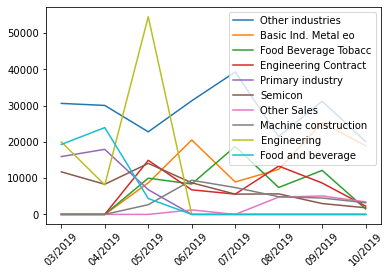

In [17]:
migrated_customer_orders_df_grouped = df_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_industries = df_orders.IndustryCode2Description.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

for name, group in migrated_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df = pd.DataFrame(0, columns = list_of_industries, index = list_of_date_bins) 

for name, group in migrated_customer_orders_df_grouped:    
    months_industry_df = group.groupby(["IndustryCode2Description"]).sum()["SalesValue"].reset_index(name='SalesValue Sum').nlargest(10, 'SalesValue Sum')
    for i in list_of_industries:
        list_of_active_industries_in_month = months_industry_df['IndustryCode2Description'].unique()
        if i in list_of_active_industries_in_month:            
            df.loc[name.date().strftime('%m/%Y')].at[i] = months_industry_df.loc[months_industry_df['IndustryCode2Description'] == i, 'SalesValue Sum'].iloc[0]
df.plot()
plt.xticks(rotation = 45)

In [18]:
# Legend movement line
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

## Sales Value by Industry - Offline

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text major ticklabel objects>)

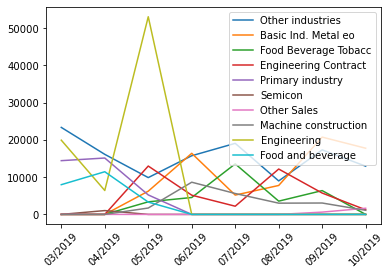

In [19]:
migrated_customer_orders_df_grouped = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Offline'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_industries = df_orders.IndustryCode2Description.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

for name, group in migrated_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df = pd.DataFrame(0, columns = list_of_industries, index = list_of_date_bins) 

for name, group in migrated_customer_orders_df_grouped:    
    months_industry_df = group.groupby(["IndustryCode2Description"]).sum()["SalesValue"].reset_index(name='SalesValue Sum').nlargest(10, 'SalesValue Sum')
    for i in list_of_industries:
        list_of_active_industries_in_month = months_industry_df['IndustryCode2Description'].unique()
        if i in list_of_active_industries_in_month:            
            df.loc[name.date().strftime('%m/%Y')].at[i] = months_industry_df.loc[months_industry_df['IndustryCode2Description'] == i, 'SalesValue Sum'].iloc[0]
df.plot()
plt.xticks(rotation = 45)

## Sales Value by Industry - Webshop

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text major ticklabel objects>)

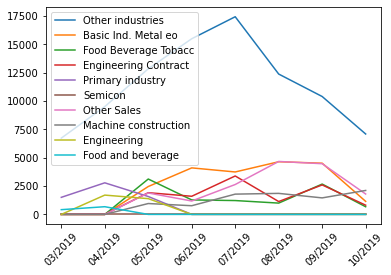

In [20]:
migrated_customer_orders_df_grouped = df_orders[df_orders['PurchaseOrderTypeDescription'] == 'Webshop'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_industries = df_orders.IndustryCode2Description.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

for name, group in migrated_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df = pd.DataFrame(0, columns = list_of_industries, index = list_of_date_bins) 

for name, group in migrated_customer_orders_df_grouped:    
    months_industry_df = group.groupby(["IndustryCode2Description"]).sum()["SalesValue"].reset_index(name='SalesValue Sum').nlargest(10, 'SalesValue Sum')
    for i in list_of_industries:
        list_of_active_industries_in_month = months_industry_df['IndustryCode2Description'].unique()
        if i in list_of_active_industries_in_month:            
            df.loc[name.date().strftime('%m/%Y')].at[i] = months_industry_df.loc[months_industry_df['IndustryCode2Description'] == i, 'SalesValue Sum'].iloc[0]
df.plot()
plt.xticks(rotation = 45)

## Breakdown by Business Unit - Import ArticleProdGroupNL - BU link table

In [21]:
df_bu = pd.read_csv(r"APGBU.csv")

## Left Join ArticleProdGroupNL with BU

In [22]:
df_orders_with_bu = df_orders.merge(right = df_bu, how = 'left', on = 'ArticleProdGroupNL')
df_orders_null_apg = df_orders_with_bu[df_orders_with_bu['BU_Eriks'].isnull()]
print ("Number of unmatched APG - BUs: ", len(df_orders_null_apg))
df_orders_with_bu['SalesDocumentHeaderCreationDate'] = pd.to_datetime(df_orders_with_bu['SalesDocumentHeaderCreationDate'])

Number of unmatched APG - BUs:  0


## % Webshop orders by BU

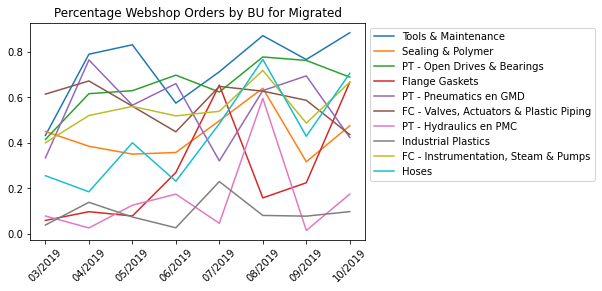

In [23]:
migrated_customer_orders_df_grouped = df_orders_with_bu.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_BUs = df_orders_with_bu.BU_Eriks.value_counts().nlargest(10).index.tolist()
list_of_date_bins = []

for name, group in migrated_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df_migrated = pd.DataFrame(0.0, columns = list_of_BUs, index = list_of_date_bins) 

for name, group in migrated_customer_orders_df_grouped:   
    only_webshop_for_scaling_df = group[group['PurchaseOrderTypeDescription'] == 'Webshop']
    only_webshop_for_scaling_df = only_webshop_for_scaling_df[only_webshop_for_scaling_df["BU_Eriks"].isin(list_of_BUs)]    
    months_bu_df = group.groupby(["BU_Eriks"]).count()["CustomerId"].reset_index(name='count')
    only_webshop_for_scaling_df = only_webshop_for_scaling_df.groupby(["BU_Eriks"]).count()["CustomerId"].reset_index(name='count')

    for i in list_of_BUs:
        list_of_active_BUs_in_month = months_bu_df['BU_Eriks'].unique()
        list_of_active_webshop_BUs_in_month = only_webshop_for_scaling_df['BU_Eriks'].unique()
        if i in list_of_active_BUs_in_month and i in list_of_active_webshop_BUs_in_month:            
            df_migrated.loc[name.date().strftime('%m/%Y')].at[i] = (1.0*only_webshop_for_scaling_df.loc[only_webshop_for_scaling_df['BU_Eriks'] == i, 'count'].iloc[0]) / (1.0*months_bu_df.loc[months_bu_df['BU_Eriks'] == i, 'count'].iloc[0]) 

df_migrated.plot()
plt.xticks(rotation = 45)
plt.title("Percentage Webshop Orders by BU for Migrated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

## Number Offline Gen Pub orders by BU

Text(0.5, 1.0, 'Number of Gen Pub Offline Orders per BU, per Month')

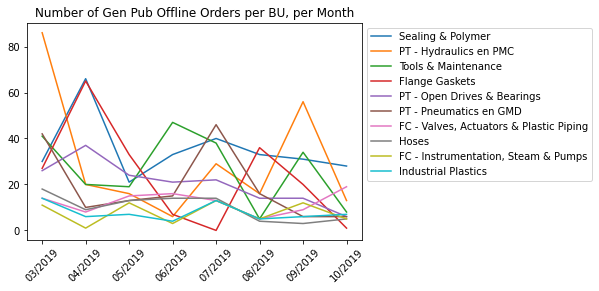

In [24]:
df_orders_with_bu_filtered = df_orders_with_bu[df_orders_with_bu['PurchaseOrderTypeDescription'] == 'Offline']
df_orders_with_bu_filtered = df_orders_with_bu_filtered[df_orders_with_bu_filtered['MaterialGroup2Description'] == 'General published']

migrated_customer_orders_df_grouped = df_orders_with_bu_filtered.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_BUs = df_orders_with_bu_filtered.BU_Eriks.value_counts().nlargest(100).index.tolist()
list_of_date_bins = []

for name, group in migrated_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df = pd.DataFrame(0, columns = list_of_BUs, index = list_of_date_bins) 

for name, group in migrated_customer_orders_df_grouped:    
    months_bu_df = group.groupby(["BU_Eriks"]).count()["CustomerId"].reset_index(name='count').nlargest(100, 'count')
    for i in list_of_BUs:
        list_of_active_BUs_in_month = months_bu_df['BU_Eriks'].unique()
        if i in list_of_active_BUs_in_month:            
            df.loc[name.date().strftime('%m/%Y')].at[i] = months_bu_df.loc[months_bu_df['BU_Eriks'] == i, 'count'].iloc[0]
df.plot()
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.title("Number of Gen Pub Offline Orders per BU, per Month")

In [25]:
df.head(n = 50)
# Managed to reproduce these values in SQL

Sealing & Polymer  PT - Hydraulics en PMC  Tools & Maintenance  \
03/2019                 30                      86                   41   
04/2019                 66                      20                   20   
05/2019                 21                      16                   19   
06/2019                 33                       6                   47   
07/2019                 40                      29                   38   
08/2019                 33                      16                    5   
09/2019                 31                      56                   34   
10/2019                 28                      13                    8   

         Flange Gaskets  PT - Open Drives & Bearings  PT - Pneumatics en GMD  \
03/2019              27                           26                      42   
04/2019              65                           37                      10   
05/2019              33                           24                      13   
06/2019               7                           21                      15   
07/2019               0                           22                      46   
08/2019              36                           14                      16   
09/2019              20                           14                       6   
10/2019               1                            6                       6   

         FC - Valves, Actuators & Plastic Piping  Hoses  \
03/2019                                       14     18   
04/2019                                        8      9   
05/2019                                       15     13   
06/2019                                       16     14   
07/2019                                       13     14   
08/2019                                        5      4   
09/2019                                        9      3   
10/2019                                       19      5   

         FC - Instrumentation, Steam & Pumps  Industrial Plastics  
03/2019                                   11                   14  
04/2019                                    1                    6  
05/2019                                   12                    7  
06/2019                                    3                    4  
07/2019                                   13                   13  
08/2019                                    5                    5  
09/2019                                   12                    6  
10/2019                                    5                    7

## % Offline Gen Pub Orders by BU

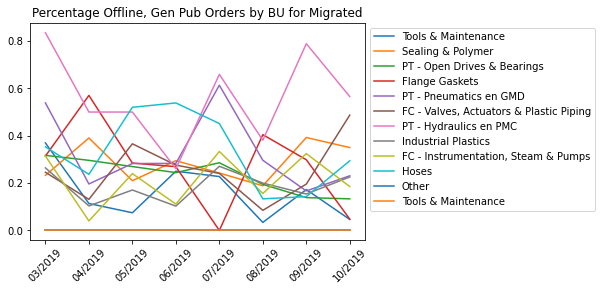

In [26]:
migrated_customer_orders_df_grouped = df_orders_with_bu.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
list_of_BUs = df_orders_with_bu.BU_Eriks.value_counts().nlargest(100).index.tolist()
list_of_date_bins = []

for name, group in migrated_customer_orders_df_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    
df_migrated = pd.DataFrame(0.0, columns = list_of_BUs, index = list_of_date_bins) 

for name, group in migrated_customer_orders_df_grouped:   
    only_offline_gen_pub_for_scaling_df = group[(group['PurchaseOrderTypeDescription'] == 'Offline') & (group['MaterialGroup2Description'] == 'General published')]
    only_offline_gen_pub_for_scaling_df = only_offline_gen_pub_for_scaling_df[only_offline_gen_pub_for_scaling_df["BU_Eriks"].isin(list_of_BUs)]    
    months_bu_df = group.groupby(["BU_Eriks"]).count()["CustomerId"].reset_index(name='count')
    only_offline_gen_pub_for_scaling_df = only_offline_gen_pub_for_scaling_df.groupby(["BU_Eriks"]).count()["CustomerId"].reset_index(name='count')

    for i in list_of_BUs:
        list_of_active_BUs_in_month = months_bu_df['BU_Eriks'].unique()
        list_of_active_offline_gen_pub_BUs_in_month = only_offline_gen_pub_for_scaling_df['BU_Eriks'].unique()
        if i in list_of_active_BUs_in_month and i in list_of_active_offline_gen_pub_BUs_in_month:            
            df_migrated.loc[name.date().strftime('%m/%Y')].at[i] = (1.0*only_offline_gen_pub_for_scaling_df.loc[only_offline_gen_pub_for_scaling_df['BU_Eriks'] == i, 'count'].iloc[0]) / (1.0*months_bu_df.loc[months_bu_df['BU_Eriks'] == i, 'count'].iloc[0]) 

df_migrated.plot()
plt.xticks(rotation = 45)
plt.title("Percentage Offline, Gen Pub Orders by BU for Migrated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [27]:
df_migrated.head(n = 50)
# Managed to reproduce these values in SQL

Tools & Maintenance  Sealing & Polymer  PT - Open Drives & Bearings  \
03/2019             0.369369           0.232558                     0.317073   
04/2019             0.113636           0.390533                     0.296000   
05/2019             0.074510           0.210000                     0.269663   
06/2019             0.250000           0.294643                     0.244186   
07/2019             0.227545           0.242424                     0.285714   
08/2019             0.033784           0.188571                     0.194444   
09/2019             0.172589           0.392405                     0.138614   
10/2019             0.046243           0.350000                     0.133333   

         Flange Gaskets  PT - Pneumatics en GMD  \
03/2019        0.313953                0.538462   
04/2019        0.570175                0.196078   
05/2019        0.284483                0.282609   
06/2019        0.269231                0.283019   
07/2019        0.000000                0.613333   
08/2019        0.404494                0.296296   
09/2019        0.298507                0.166667   
10/2019        0.047619                0.230769   

         FC - Valves, Actuators & Plastic Piping  PT - Hydraulics en PMC  \
03/2019                                 0.245614                0.834951   
04/2019                                 0.131148                0.500000   
05/2019                                 0.365854                0.500000   
06/2019                                 0.275862                0.260870   
07/2019                                 0.240741                0.659091   
08/2019                                 0.084746                0.380952   
09/2019                                 0.195652                0.788732   
10/2019                                 0.487179                0.565217   

         Industrial Plastics  FC - Instrumentation, Steam & Pumps     Hoses  \
03/2019             0.264151                             0.314286  0.352941   
04/2019             0.103448                             0.040000  0.236842   
05/2019             0.170732                             0.240000  0.520000   
06/2019             0.102564                             0.111111  0.538462   
07/2019             0.270833                             0.333333  0.451613   
08/2019             0.200000                             0.156250  0.133333   
09/2019             0.153846                             0.324324  0.142857   
10/2019             0.225806                             0.185185  0.294118   

         Other  Tools & Maintenance   
03/2019    0.0                   0.0  
04/2019    0.0                   0.0  
05/2019    0.0                   0.0  
06/2019    0.0                   0.0  
07/2019    0.0                   0.0  
08/2019    0.0                   0.0  
09/2019    0.0                   0.0  
10/2019    0.0                   0.0

# Part 2 - Discount Analysis

## Data Import and cleaning

In [28]:
# Read in IDs and discount information 
df_discounts = pd.read_csv(r"Discount_Data.csv")
df_discounts.CustomerId = df_discounts.CustomerId.astype(str) 
df_discounts['CustomerId'].value_counts() # Some people have multiple entries, 1801584 has different email entries

1801584    3
1786019    2
1019354    2
1687220    2
1011733    2
          ..
1803399    1
1013999    1
1820586    1
1677696    1
1730645    1
Name: CustomerId, Length: 1756, dtype: int64

## Drop Duplicates 

In [29]:
discount_customer_ids = df_discounts['CustomerId'].unique()
df_discounts['CustomerId'].nunique()

1756

## Sanity check of all customers in discounts list


In [30]:
sql_list = "("
for x in range(len(discount_customer_ids)):
    sql_list += "'" + str(discount_customer_ids[x]) + "'" + ", " 
sql_list = sql_list[:-2]
sql_list += ")"

script_after = "Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in %s" %sql_list
print (script_after)

Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in ('1732501', '1005507', '1781141', '1660106', '1799581', '1820772', '1820734', '1685986', '1784992', '1005936', '1807048', '1718416', '1662876', '1695115', '1709946', '1814858', '1820634', '1006232', '1007645', '1620793', '1692799', '1006333', '1006397', '1811873', '1006824', '1006977', '1820179', '1732332', '1803129', '1718474', '1007514', '1820418', '1023350', '1799307', '1820624', '1799461', '1820751', '1693995', '1032653', '1692888', '1661782', '1710712', '1680736', '1011551', '1820692', '1057968', '1730006', '1661489', '1017365', '1732275', '1007528', '1687220', '1681521', '1661548', '1820623', '105

In [31]:
df_all_discount_orders = pd.read_csv(r"orders_data_all_customers_in_discount_dataset.csv")
df_all_discount_orders.TurnoverClass = df_all_discount_orders.TurnoverClass.astype(str)
df_all_discount_orders.CustomerId = df_all_discount_orders.CustomerId.astype(str)
df_all_discount_orders['SalesDocumentHeaderCreationDate'] = pd.to_datetime(df_all_discount_orders['SalesDocumentHeaderCreationDate'])

In [32]:
#Run this in SQL to update order data
sql_list = "("
for x in range(len(discount_customer_ids)):
    sql_list += "'" + str(discount_customer_ids[x]) + "'" + ", " 
sql_list = sql_list[:-2]
sql_list += ")"

script_after = "Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in %s" %sql_list
print (script_after)

Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in ('1732501', '1005507', '1781141', '1660106', '1799581', '1820772', '1820734', '1685986', '1784992', '1005936', '1807048', '1718416', '1662876', '1695115', '1709946', '1814858', '1820634', '1006232', '1007645', '1620793', '1692799', '1006333', '1006397', '1811873', '1006824', '1006977', '1820179', '1732332', '1803129', '1718474', '1007514', '1820418', '1023350', '1799307', '1820624', '1799461', '1820751', '1693995', '1032653', '1692888', '1661782', '1710712', '1680736', '1011551', '1820692', '1057968', '1730006', '1661489', '1017365', '1732275', '1007528', '1687220', '1681521', '1661548', '1820623', '105

## Plot all orders for all customers in discount dataset (discount and no discount)

[5313, 5024, 4763, 4188, 4648, 4094, 4480, 3908]


Text(0.5, 1.0, 'Orders over time from all customers in discount dataset')

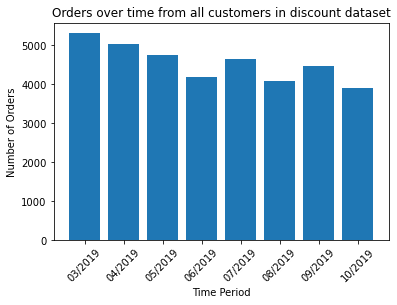

In [33]:
df_all_discount_orders_grouped = df_all_discount_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_group_sizes = []
for name, group in df_all_discount_orders_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes.append(len(group.index))

plt.bar(list_of_date_bins, list_of_group_sizes)
plt.xticks(rotation = 45)
print (list_of_group_sizes)
plt.xlabel("Time Period")
plt.ylabel("Number of Orders")
plt.title("Orders over time from all customers in discount dataset")

## Number of Discount vs No Discount customers

In [34]:
Discount_customerIDs_list = df_discounts[(df_discounts['Email'] == 'Ja, 1e maand 10%') | (df_discounts['Email'] == 'Ja, 10% op 1e order') | ((df_discounts['Email'] == 'Inform') & (df_discounts['Existing'] == 'Zamro')) ]['CustomerId'].unique()
print (len(Discount_customerIDs_list))
No_discount_customerIDs_list = df_discounts[(df_discounts['Email'] == 'Geen') | ((df_discounts['Email'] == 'Inform') & (df_discounts['Existing'] == 'ERIKS')) ]['CustomerId'].unique()
print (len(No_discount_customerIDs_list))


881
888


## Generate SQL queries for discount vs no discount customers

In [35]:
sql_list = "("
for x in range(len(Discount_customerIDs_list)):
    sql_list += "'" + str(Discount_customerIDs_list[x]) + "'" + ", " 
sql_list = sql_list[:-2]
sql_list += ")"

script_discount = "Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in %s" % sql_list
print (script_discount)

Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in ('1005507', '1799581', '1820772', '1820734', '1685986', '1784992', '1005936', '1807048', '1718416', '1662876', '1814858', '1006232', '1006333', '1006397', '1006977', '1820179', '1803129', '1799307', '1820751', '1692888', '1661782', '1710712', '1680736', '1820692', '1730006', '1017365', '1007528', '1681521', '1666616', '1784372', '1007788', '1007979', '1725934', '1714027', '1784635', '1775114', '1694486', '1804596', '1008045', '1738528', '1008345', '1013074', '1008499', '1796419', '1008629', '1008662', '1775086', '1009485', '1009723', '1820730', '1010389', '1820798', '1010621', '1010639', '1689042', '101

In [36]:
sql_list = "("
for x in range(len(No_discount_customerIDs_list)):
    sql_list += "'" + str(No_discount_customerIDs_list[x]) + "'" + ", " 
sql_list = sql_list[:-2]
sql_list += ")"

script_no_discount = "Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in %s" % sql_list
print (script_no_discount)

Select OriginalOrderNumber, OrderNumber, CustomerId, CustomerName, TurnoverClass, IndustryCode2Description, ArticleProdGroupNL, PurchaseOrderTypeDescription, SalesDocumentHeaderCreationDate, SalesValue, Quantity, MaterialGroup2Description FROM [weekly].[OrdersNLBE] Where SalesDocumentHeaderCreationDate >= '2019-03-01' and SalesDocumentHeaderCreationDate <= '2019-10-25' and CustomerId in ('1732501', '1781141', '1660106', '1695115', '1709946', '1820634', '1007645', '1620793', '1692799', '1811873', '1006824', '1732332', '1718474', '1007514', '1820418', '1023350', '1820624', '1799461', '1693995', '1032653', '1011551', '1057968', '1661489', '1732275', '1687220', '1661548', '1820623', '1050619', '1775804', '1725960', '1021788', '1820641', '1018233', '1731619', '1027319', '1732474', '1040486', '1022570', '1006235', '1820820', '1806322', '1014469', '1688156', '1057583', '1670932', '1020280', '1768920', '1819138', '1797858', '1013923', '1666406', '1679632', '1701923', '1779739', '1017455', '181

## Import Separate Datasets

In [37]:
df_discount_orders = pd.read_csv(r"orders_data_discount_group.csv")
df_no_discount_orders = pd.read_csv(r"orders_data_no_discount_group.csv")

## Cleaning

In [38]:
df_discount_orders.TurnoverClass = df_discount_orders.TurnoverClass.astype(str)
df_discount_orders.CustomerId = df_discount_orders.CustomerId.astype(str)
df_discount_orders['SalesDocumentHeaderCreationDate'] = pd.to_datetime(df_discount_orders['SalesDocumentHeaderCreationDate'])

df_no_discount_orders.TurnoverClass = df_no_discount_orders.TurnoverClass.astype(str)
df_no_discount_orders.CustomerId = df_no_discount_orders.CustomerId.astype(str)
df_no_discount_orders['SalesDocumentHeaderCreationDate'] = pd.to_datetime(df_no_discount_orders['SalesDocumentHeaderCreationDate'])

## Number of orders per month

Text(0.5, 1.0, 'Orderlines over time from customers given discount')

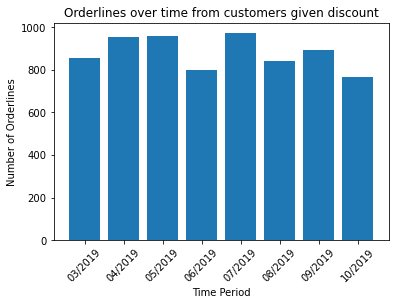

In [39]:
df_discount_orders_grouped = df_discount_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_group_sizes = []
for name, group in df_discount_orders_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes.append(len(group.index))

plt.bar(list_of_date_bins, list_of_group_sizes)
plt.xticks(rotation = 45)
plt.xlabel("Time Period")
plt.ylabel("Number of Orderlines")
plt.title("Orderlines over time from customers given discount")

Text(0.5, 1.0, 'Orders over time from customers not given discount')

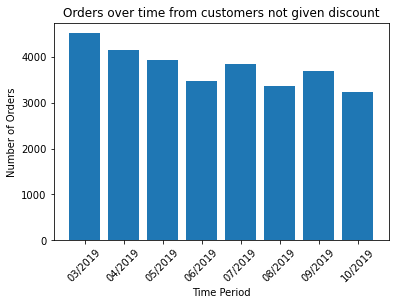

In [40]:
df_no_discount_orders_grouped = df_no_discount_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_group_sizes = []
for name, group in df_no_discount_orders_grouped:
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes.append(len(group.index))

plt.bar(list_of_date_bins, list_of_group_sizes)
plt.xticks(rotation = 45)
plt.xlabel("Time Period")
plt.ylabel("Number of Orders")
plt.title("Orders over time from customers not given discount")

## Average % online

Text(0, 0.5, 'Percentage')

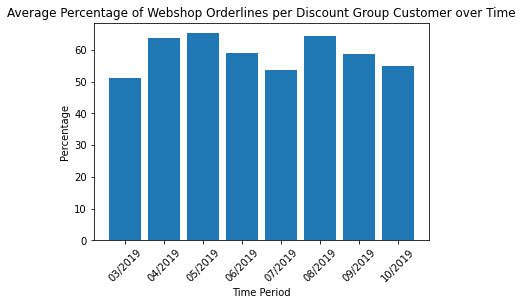

In [41]:
df_discount_orders_grouped = df_discount_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_average_online_orders = []
for name, group in df_discount_orders_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_averages_in_one_month = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_averages_in_one_month.append( len(customer_dataframe[customer_dataframe['PurchaseOrderTypeDescription'] == 'Webshop']) / len(customer_dataframe))
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_online_orders.append(100*np.mean(list_of_customer_averages_in_one_month))

plt.bar(list_of_date_bins, list_of_average_online_orders)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Percentage of Webshop Orderlines per Discount Group Customer over Time")
plt.ylabel("Percentage")

Text(0, 0.5, 'Percentage')

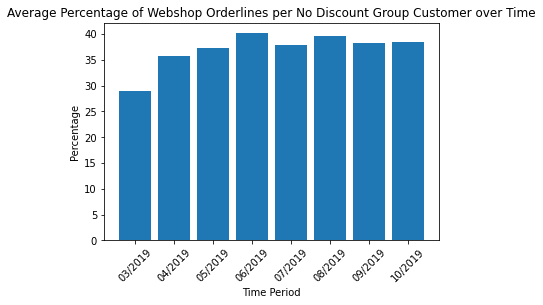

In [42]:
df_no_discount_orders_grouped = df_no_discount_orders.groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins = []
list_of_average_online_orders = []
for name, group in df_no_discount_orders_grouped:
    customer_level_group_by = group.groupby("CustomerId")
    list_of_customer_averages_in_one_month = []
    for customer, customer_dataframe in customer_level_group_by:  
        list_of_customer_averages_in_one_month.append( len(customer_dataframe[customer_dataframe['PurchaseOrderTypeDescription'] == 'Webshop']) / len(customer_dataframe))
    list_of_date_bins.append(name.date().strftime('%m/%Y'))
    list_of_average_online_orders.append(100*np.mean(list_of_customer_averages_in_one_month))

plt.bar(list_of_date_bins, list_of_average_online_orders)
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.title("Average Percentage of Webshop Orderlines per No Discount Group Customer over Time")
plt.ylabel("Percentage")

## Offline order analysis - Customers with discount

Text(0.5, 1.0, 'Breakup of Offline Orders per Month for Discounted Customers')

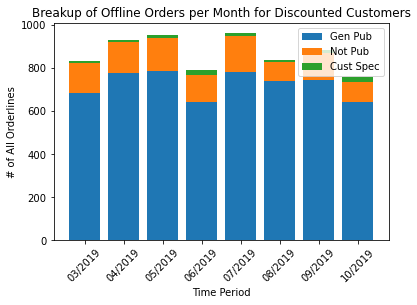

In [43]:
discounted_offline_df = df_discount_orders[df_discount_orders['PurchaseOrderTypeDescription'] == 'Offline']
discounted_genpub_df = df_discount_orders[df_discount_orders['MaterialGroup2Description'] == 'General published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
discounted_notpub_df = df_discount_orders[df_discount_orders['MaterialGroup2Description'] == 'Do not publish'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
discounted_custspec_df = df_discount_orders[df_discount_orders['MaterialGroup2Description'] == 'Customer-specific published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_genpub = []
list_of_group_sizes_genpub = []
for name, group in discounted_genpub_df:
    list_of_date_bins_genpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_genpub.append(group.shape[0])

list_of_date_bins_notpub = []
list_of_group_sizes_notpub = []
for name, group in discounted_notpub_df:
    list_of_date_bins_notpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_notpub.append(group.shape[0])
    
list_of_date_bins_custspec = []
list_of_group_sizes_custspec = []
for name, group in discounted_custspec_df:
    list_of_date_bins_custspec.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_custspec.append(group.shape[0])

list_of_group_sizes_genpub_normed = [x*100 / (float(len(df_orders))) for x in list_of_group_sizes_genpub]
list_of_group_sizes_notpub_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_notpub]
list_of_group_sizes_custspec_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_custspec]

genpub_plus_notpub = [x + y for x, y in zip(list_of_group_sizes_genpub, list_of_group_sizes_notpub)]
genpub_plus_notpub_normed = [x + y for x, y in zip(list_of_group_sizes_genpub_normed, list_of_group_sizes_notpub_normed)]

plt.bar(list_of_date_bins_genpub, list_of_group_sizes_genpub, label = 'Gen Pub')
plt.bar(list_of_date_bins_notpub, list_of_group_sizes_notpub, bottom = list_of_group_sizes_genpub, label = 'Not Pub')
plt.bar(list_of_date_bins_custspec, list_of_group_sizes_custspec, bottom = genpub_plus_notpub, label = 'Cust Spec')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("# of All Orderlines")
plt.title("Breakup of Offline Orders per Month for Discounted Customers")

## Offline order analysis - Customers without discount

Text(0.5, 1.0, 'Breakup of Offline Orders per Month for No Discount Customers')

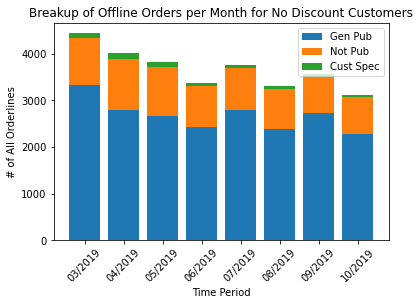

In [44]:
not_discounted_offline_df = df_no_discount_orders[df_no_discount_orders['PurchaseOrderTypeDescription'] == 'Offline']
not_discounted_genpub_df = df_no_discount_orders[df_no_discount_orders['MaterialGroup2Description'] == 'General published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
not_discounted_notpub_df = df_no_discount_orders[df_no_discount_orders['MaterialGroup2Description'] == 'Do not publish'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))
not_discounted_custspec_df = df_no_discount_orders[df_no_discount_orders['MaterialGroup2Description'] == 'Customer-specific published'].groupby(pd.Grouper(key = "SalesDocumentHeaderCreationDate", freq='M'))

list_of_date_bins_genpub = []
list_of_group_sizes_genpub = []
for name, group in not_discounted_genpub_df:
    list_of_date_bins_genpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_genpub.append(group.shape[0])

list_of_date_bins_notpub = []
list_of_group_sizes_notpub = []
for name, group in not_discounted_notpub_df:
    list_of_date_bins_notpub.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_notpub.append(group.shape[0])
    
list_of_date_bins_custspec = []
list_of_group_sizes_custspec = []
for name, group in not_discounted_custspec_df:
    list_of_date_bins_custspec.append(name.date().strftime('%m/%Y'))
    list_of_group_sizes_custspec.append(group.shape[0])

list_of_group_sizes_genpub_normed = [x*100 / (float(len(df_orders))) for x in list_of_group_sizes_genpub]
list_of_group_sizes_notpub_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_notpub]
list_of_group_sizes_custspec_normed = [x*100 / float(len(df_orders)) for x in list_of_group_sizes_custspec]

genpub_plus_notpub = [x + y for x, y in zip(list_of_group_sizes_genpub, list_of_group_sizes_notpub)]
genpub_plus_notpub_normed = [x + y for x, y in zip(list_of_group_sizes_genpub_normed, list_of_group_sizes_notpub_normed)]

plt.bar(list_of_date_bins_genpub, list_of_group_sizes_genpub, label = 'Gen Pub')
plt.bar(list_of_date_bins_notpub, list_of_group_sizes_notpub, bottom = list_of_group_sizes_genpub, label = 'Not Pub')
plt.bar(list_of_date_bins_custspec, list_of_group_sizes_custspec, bottom = genpub_plus_notpub, label = 'Cust Spec')

plt.legend()
plt.xticks(rotation = 45)

plt.xlabel("Time Period")
plt.ylabel("# of All Orderlines")
plt.title("Breakup of Offline Orders per Month for No Discount Customers")